In [1]:
import numpy as np
import torch
import pandas as pd 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
import csv

cuda = True if torch.cuda.is_available() else False
print(f'Cuda is on: {cuda}')
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Cuda is on: True


In [11]:
class CausalConv2d(torch.nn.Conv2d):
    
    ''' Causal Convolutional Neural Network in 1-D. Basically a special case of CNN-1d
    so its generator inherents from torch.nn.Conv1d class.

    '''
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride = 1,
                 dilation = 1,
                 groups = 1,
                 bias = True):
        
        super(CausalConv2d, self).__init__(
            in_channels,
            out_channels,
            kernel_size = kernel_size,
            padding = 0,
            stride = stride,
            dilation = dilation,
            groups = groups,
            bias = True)
        
        self.__padding = (kernel_size[1] - 1) * dilation
        
    def forward(self, input):
        return super(CausalConv2d, self).forward(F.pad(input, (0,self.__padding)))
    


In [12]:
class context_embedding(torch.nn.Module):
    
    '''
       Embedding the context. You can understand this as construct a model using causal CNN.
       However, the return value is sigmoided.
    '''
    def __init__(self,
                 in_channels = 1,
                 embedding_size = 256,
                 k = 5):
        super(context_embedding, self).__init__()
        
        self.causal_convolution = CausalConv2d(in_channels,
                                               embedding_size,
                                               kernel_size = k)
        
    def forward(self, x):
        
        x = self.causal_convolution(x)
        
        return F.sigmoid(x)

In [13]:
class GetData(Dataset):
    
    '''
        Get dataset 
    '''
    
    def __init__(self,target,feature,t0=96,to_predict = 24,transform=None):
        
        self.t0 = t0 # known time step
        self.transform = None
        
        length = target.shape[0]
        step = t0+to_predict ##step in one data point (known + topredict)
        
        eff_len = length - step + 1 ## effective length of the whole time series i.e. can be break in to how many data points
        
        Y = []
        F = []
        
        for i in range(eff_len):
            Y.append(target[i:step+i].unsqueeze(0))## size * time step
            F.append(feature[i:step+i].unsqueeze(0).permute(0,2,1)) ## size * feature size * time step
        
        self.target = torch.cat(Y) ## size * dimension
        self.feature = torch.cat(F)
        
        
        
        self.time = torch.cat(eff_len*[torch.arange(0,step).type(torch.float).unsqueeze(0)])
        
        
        self.masks = self._generate_square_subsequent_mask(t0)
                
        
        # print out shapes to confirm desired output
        print(self.time.shape)   
        print(self.target.shape)
        
    def __len__(self):
        return self.target.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        sample = (self.time[idx,:],
                  self.target[idx,:],
                  self.feature[idx,:],
                  self.masks) #in tuple shape, will be called in training, eval and testing.
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self,t0):
        mask = torch.zeros(t0+to_predict,t0+to_predict)
        for i in range(0,t0):
            mask[i,t0:] = 1 
        for i in range(t0,t0+to_predict):
            mask[i,i:] = 1
        mask = mask.float().masked_fill(mask == 1, float('-inf'))#.masked_fill(mask == 1, float(0.0))
        return mask

In [14]:
#model

class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self,feature_dim,nhead = 16,num_layers = 8,d_model = 512,conv_len = 5,feature_weight = True,embedding_weight = True):
        super(TransformerTimeSeries,self).__init__()
        self.feature_weight = feature_weight
        self.embedding_weight = embedding_weight
        self.feature_dim = feature_dim
        self.input_embedding_y = context_embedding(1,d_model,(1,conv_len))
        
        if feature_weight:
            self.input_embedding_f = context_embedding(1,d_model,(1,conv_len))
            self.feature_projection = torch.nn.Linear(feature_dim,1)
        else:
            self.input_embedding_f = context_embedding(1,d_model,(feature_dim,conv_len))
        
        
        
        if embedding_weight:
            self.embbeding_projection = torch.nn.Linear(3,1)
            
        self.bn = torch.nn.BatchNorm2d(1)
        self.positional_embedding = torch.nn.Embedding(2*d_model,d_model)
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers = num_layers)
        
        self.fc1 = torch.nn.Linear(d_model,1)

        
    def forward(self,x,y,feature,attention_masks):
        
        
        z = y.unsqueeze(1).unsqueeze(1) ## reshape it so it can be processed by 2D CNN
        z = self.bn(z) ##Batch Norm
        
        if self.feature_dim > 1:    
            f = feature.unsqueeze(1)## embedding of nulti-dim feature
        
        else:
            f = feature.unsqueeze(1).unsqueeze(1) ## One dim feature 
        
        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
        z_embedding = self.input_embedding_y(z).squeeze().permute(2,0,1) ## embedding of target
        
        if self.feature_weight:
            
            f_embedding = self.input_embedding_f(f).squeeze()
            f_embedding = f_embedding.permute(0,1,3,2) ## multi dim feature
            f_embedding = self.feature_projection(f_embedding).squeeze() ## linear combination of features' embeddings
            f_embedding = f_embedding.permute(2,0,1)
            
        else:
            f_embedding = self.input_embedding_f(f).squeeze().permute(2,0,1)
            
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
        positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)
        
    
        if self.embedding_weight:
            all_embedding = torch.cat([z_embedding.unsqueeze(3),positional_embeddings.unsqueeze(3),f_embedding.unsqueeze(3)],3)
            input_embedding = self.embbeding_projection(all_embedding)## the linear combination of three embeddings
            input_embedding = input_embedding.squeeze()
        else:
            input_embedding = z_embedding + positional_embeddings + f_embedding ## add up directly
        
        transformer_embedding = self.transformer_decoder(input_embedding,attention_masks)
        
        output = self.fc1(transformer_embedding.permute(1,0,2))
        

        return output

#### Above is model definition

In [15]:
t0 = 5 ## number of input
to_predict = 1 ## days to predict
criterion = torch.nn.MSELoss()

## Visualize  output

In [39]:
stock = 'AAPL'  ## you may change to AMZN or GOOG or AAPL_12

##### For visualization, please specify which stocks, you may choose AAPL, AMZN, GOOG, and AAPL_12 (12 year version)

In [40]:
file_name = f'{stock}_features.csv'
##load data
with open(file_name) as f:
    data_list = csv.reader(f)
    data = []
    for row in data_list:
        data.append(row)
    f.close()
    
data = torch.tensor(np.delete(np.array(data)[1:,2:],4,axis = 1).astype(np.float)).type(torch.float)
## drop the adj close


feature_dim = data.shape[1] - 1
## get feature dimension
rate = []
for i in range(1,data.shape[0]):
    rate.append((100*(data[i,0:4] - data[i-1,0:4])/data[i-1,0:4]).reshape(1,4))
## convert OHLC to rate    
rate = torch.cat(rate)
rate_data = torch.cat([rate,data[1:,4:]],1)
train_size = int(data.shape[0]*0.9)
data_train = rate_data[0:train_size]
data_test = rate_data[train_size-4:]


##### graphing

In [43]:
To_load = f'{stock}' 
## This is for open price. If to see the High, Low, and Close, change f'{stock}' to f'{stock}_H
##f'{stock}_L f'{stock}_C respectivly

##### This is for open price. If to see the High, Low, and Close, change f'{stock}' to f'{stock}_H, or f'{stock}_L , or f'{stock}_C respectivly. 
##### Note that AAPL_12 only have Open price prediction

torch.Size([431, 6])
torch.Size([431, 6])
torch.Size([47, 6])
torch.Size([47, 6])
AAPL MAE is 0.24553631246089935
AAPL MSE is 0.26247721910476685
AAPL RMSE is 0.5123253059382943


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


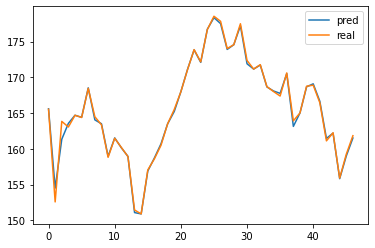

In [44]:
train_dataset = GetData(data_train[:,0],data_train[:,1:],t0 = t0, to_predict = to_predict)
test_dataset = GetData(data_test[:,0],data_test[:,1:],t0 = t0, to_predict = to_predict)

train_dl = DataLoader(train_dataset,batch_size=256,shuffle=True)
test_dl = DataLoader(test_dataset,batch_size=512)

bmodel = TransformerTimeSeries(feature_dim = feature_dim,
                                  nhead = 4,num_layers = 12,d_model = 512,
                                  conv_len = 5,feature_weight = True,embedding_weight = True)

bmodel.load_state_dict(torch.load(To_load))## load model
bmodel.to(device)
bmodel.eval()
with torch.no_grad(): # eliminate gradient i.e. gradients only exists in train()

    for step,(x,y,feature,attention_masks) in enumerate(test_dl):
        x = x.to(device)
        y = y.to(device)
        feature = feature.to(device)
        attention_masks = attention_masks.to(device)
        output = bmodel(x,y,feature,attention_masks[0])
        
        pred = data[train_size + 1 :-1,0]*0.01*(100+output[:,t0:].squeeze()).detach().cpu() #prediction
        ## note that test set starts at index train_size + 1 because idex train_size in rate_data 
        ## is the last day of first test data point, but rate_data only have the second til last data points
        ## of the dataset.
        real = data[train_size + 1 :-1,0]*0.01*(100+y[:,t0:].squeeze()).detach().cpu()##real data

        plt.plot(pred)
        plt.plot(real)
        plt.legend(['pred','real'])##plot
        MAE = torch.nn.L1Loss()(pred,real).item()
        MSE = torch.nn.MSELoss()(pred,real).item()
        RMSE = np.sqrt(MSE)
        
        print(f'{stock} MAE is {MAE}')
        print(f'{stock} MSE is {MSE}')
        print(f'{stock} RMSE is {RMSE}')##print loss